# Making Many Filtered Maps

I need to generate many filtered maps at the same time to look at the population of them.

In [1]:
N_PLANCK_SIMS = 10
N_OUTPUT_SIMS = 10
NSIDE_OUTPUT  = 512
DETECTOR      = 545
WHT_SEED      = 42   # seed for the white noise sims

## Boilerplate and Helper functions

In [2]:
# imports
import logging
import sys
import numpy as np
from sklearn.decomposition import PCA

from tqdm import tqdm

import healpy as hp
import matplotlib.pyplot as plt
import pysm3.units as u

from cmbml.utils.handle_data import (
    get_planck_obs_data, 
    get_planck_noise_data, 
    # get_planck_hm_data, 
    get_map_dtype
    )
from cmbml.utils.fits_inspection import get_field_unit

from system_config import ASSETS_DIRECTORY, PLANCK_NOISE_DIRECTORY

In [3]:
# Logging was helpful when debugging my handle_data module
logging.basicConfig(
    level=logging.WARNING,  # If DEBUG, there's a bunch of PySM3 and Matplotlib stuff
    format='%(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)

In [4]:
def plot_many_ps(ps_s,
            title=None, 
            x_low=0.7,
            x_high=1e4,
            y_low=1e-4,
            y_high=1e-2,
            styles=None,
            labels=None,
            white_noise_expected=None,
            legend=True,
            focus_first=False):
    y_label="$N_{\\ell}$" + f"(unit)"
    x_label="$\\ell$"
    plt.figure()
    for i, ps in enumerate(ps_s):
        ells = np.arange(len(ps)).astype(float)
        if x_low < 1:
            ells[0] = x_low
        style=None
        linewidth=None
        color=None
        if styles is None:
            pass
        elif styles[i] != "-":
            style = styles[i]
            linewidth = 2
        else:
            style = styles[i]
            linewidth = 1
        if focus_first and i == 0:
            color='black'
            linewidth=3
        label = None if labels is None else labels[i]
        plt.plot(ells, ps, label=label, linestyle=style, color=color, linewidth=linewidth)
    # if white_noise_expected is not None:
    #     plt.axhline(y=white_noise_expected, color='black', linestyle='--', linewidth=1)
    #     plt.text(y=white_noise_expected, x=x_high, s="$\\sigma_{\\ell}=" + f"{white_noise_expected:.1e}$", 
    #              color='black',
    #              horizontalalignment='right', verticalalignment='bottom')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([x_low-0.00001, x_high])
    plt.ylim([y_low, y_high])
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

In [5]:
CENTER_FREQS = {
    30: 28.4 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    44: 44.1 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    70: 70.4 * u.GHz,      # Value from Planck DeltaBandpassTable & Planck 2018 I, Table 4
    100: 100.89 * u.GHz,   # Value from Planck DeltaBandpassTable
    143: 142.876 * u.GHz,  # Value from Planck DeltaBandpassTable
    217: 221.156 * u.GHz,  # Value from Planck DeltaBandpassTable
    353: 357.5 * u.GHz,    # Value from Planck DeltaBandpassTable
    545: 555.2 * u.GHz,    # Value from Planck DeltaBandpassTable
    857: 866.8 * u.GHz,    # Value from Planck DeltaBandpassTable
}

In [6]:
def get_xxcov_field_num(detector, field_str):
    if detector not in [30, 44, 70, 100, 143, 217, 353, 545, 857]:
        raise ValueError(f"Detector {detector} not recognized")
    field_str = field_str.lower()
    lower_field_nums = dict(ii=4, iq=5, iu=6, qq=7, qu=8, uu=9)
    upper_field_nums = dict(ii=2)  # These detectors only have intensity data
    if detector in [545, 857]:
        if field_str not in upper_field_nums.keys():
            raise ValueError(f"Field {field_str} not available for detector {detector}")
        res = upper_field_nums[field_str]
    else:
        if field_str not in ['ii', 'iq', 'iu', 'qq', 'qu', 'uu']:
            raise ValueError(f"Field {field_str} not available for detector {detector}")
        res = lower_field_nums[field_str]
    return res

In [7]:
def _change_variance_map_resolution(m, nside_out):
    # For variance maps, because statistics
    power = 2

    # From PySM3 template.py's read_map function, with minimal alteration (added 'power'):
    m_dtype = get_map_dtype(m)
    nside_in = hp.get_nside(m)
    if nside_out < nside_in:  # do downgrading in double precision, per healpy instructions
        m = hp.ud_grade(m.astype(np.float64), power=power, nside_out=nside_out)
    elif nside_out > nside_in:
        m = hp.ud_grade(m, power=power, nside_out=nside_out)
    m = m.astype(m_dtype, copy=False)
    # End of used portion

    return m

In [8]:
def convert_field_str_to_Unit(unit_str):
    custom_units = {
            # 'uK_CMB': u.uK_CMB,
            'Kcmb': u.K_CMB,
            # 'K_CMB': u.K_CMB,
            'MJy/sr': u.MJy / u.sr,
            'Kcmb^2': u.K_CMB**2,
            '(K_CMB)^2': u.K_CMB**2,
            # 'K_CMB^2': u.K_CMB**2,
            # 'uK_CMB^2': u.uK_CMB**2,
            # '(uK_CMB)^2': u.uK_CMB**2,
            # '(MJy/sr)^2': (u.MJy / u.sr)**2,
            '(Mjy/sr)^2': (u.MJy / u.sr)**2,
            # 'MJy/sr^2': (u.MJy / u.sr)**2
        }
    if not isinstance(unit_str, str):
        try:
            unit_str = unit_str.item()
        except AttributeError:
            raise TypeError(f"Expected a string, but got {type(unit_str)}")

    try:
        # Attempt to parse with Astropy's Unit function
        return u.Unit(unit_str)
    except ValueError:  # Astropy throws a ValueError for unrecognized units
        if unit_str in custom_units.keys():
            return custom_units[unit_str]
        else:
            raise ValueError(f"Unit {unit_str} not recognized.")

In [9]:
def get_scale_map(det, nside_out):
    obs_fn = get_planck_obs_data(detector=det, assets_directory=ASSETS_DIRECTORY)
    use_field = get_xxcov_field_num(det, 'II')
    II_cov_map = hp.read_map(obs_fn, hdu=1, field=use_field)
    II_cov_map_512 = _change_variance_map_resolution(II_cov_map, nside_out)
    scale_map = np.sqrt(II_cov_map_512)

    var_map_unit = get_field_unit(obs_fn, hdu=1, field_idx=use_field)
    var_map_unit = convert_field_str_to_Unit(var_map_unit)
    scale_map_unit = var_map_unit**0.5
    scale_map = u.Quantity(scale_map, unit=scale_map_unit)

    return scale_map

In [10]:
def get_target_cls_from_pca_results(n_sims, src_mean_ps, src_variance, src_components):
    num_components = len(src_variance)

    std_devs = np.sqrt(src_variance)

    if n_sims == 1:
        reduced_shape = (num_components,)
    else:
        reduced_shape = (n_sims, num_components)

    reduced_samples = np.random.normal(0, std_devs, reduced_shape)
    # Reconstruct power spectra in log10 space
    tgt_log_ps = reduced_samples @ src_components + src_mean_ps
    # Convert out of log10 space
    tgt_cls = 10**tgt_log_ps
    return tgt_cls

In [11]:
def make_tgt_noise_params_from_det_file(det, n_sims):
    data = np.load(f"noise_models2/noise_model_{det}GHz.npz")

    src_mean_ps     = data['mean_ps']
    src_components  = data['components']
    src_variance    = data['variance']

    # src_mean_maps   = data['maps_mean']
    # src_sd_maps     = data['maps_sd']

    src_map_unit    = data['maps_unit'].item()

    src_map_unit = convert_field_str_to_Unit(src_map_unit)

    tgt_cls = get_target_cls_from_pca_results(n_sims, src_mean_ps, src_variance, src_components)

    return tgt_cls, src_map_unit

In [12]:
def downgrade_map_via_alm(some_map, target_nside):
    try:
        map_unit = some_map.unit
    except AttributeError:
        map_unit = None
    source_nside = hp.get_nside(some_map)
    assert target_nside <= source_nside/2, "Target nside must be less than the source nside"
    lmax_source = 3 * source_nside - 1
    alm = hp.map2alm(some_map, lmax=lmax_source)

    lmax_target = int(3 * target_nside - 1)
    alm_filter = np.zeros(lmax_source+1)
    alm_filter[:lmax_target+1] = 1
    alm_filtered = hp.almxfl(alm, alm_filter)
    some_map_filtered = hp.alm2map(alm_filtered, nside=target_nside)
    if map_unit is not None:
        some_map_filtered = u.Quantity(some_map_filtered, unit=map_unit)
    return some_map_filtered

In [13]:
def get_map_with_unit(fn):
    map_ = hp.read_map(fn)
    map_units = get_field_unit(fn, hdu=1, field_idx=0)
    map_units = convert_field_str_to_Unit(map_units)
    return map_ * map_units

In [14]:
def get_avg_map(detector, nside_out):
    fn = f"noise_avgs/avg_noise_map_{detector}_TQU_100.fits"
    planck_nse_avg = get_map_with_unit(fn)
    if hp.get_nside(planck_nse_avg) != nside_out:
        planck_nse_avg = downgrade_map_via_alm(planck_nse_avg, nside_out)
    return planck_nse_avg

In [15]:
def get_lmax_for_nside(nside):
    """Helper function: Max ell for a given nside; to be considered a parameter"""
    return 3 * nside - 1

In [16]:
def get_autopower(map_, mask, lmax):
    return get_xpower(map1=map_, map2=None, mask=mask, lmax=lmax)

def get_xpower(map1, map2, mask, lmax, use_pixel_weights=False):
    if mask is None:
        ps = hp.anafast(map1, map2, lmax=lmax, use_pixel_weights=use_pixel_weights)
    else:
        mean1 = np.sum(map1*mask)/np.sum(mask)
        input1 = mask*(map1-mean1)
        if map2 is None:
            input2 = None
        else:
            mean2 = np.sum(map2*mask)/np.sum(mask)
            input2 = mask*(map2-mean2)
        fsky = np.sum(mask)/mask.shape[0]
        ps = hp.anafast(input1,
                        input2,
                        lmax=lmax,
                        use_pixel_weights=use_pixel_weights)
        ps = ps / fsky
    return ps

# Making Model

In [17]:
def make_mask(nside, width=10):
    mask = np.ones(hp.nside2npix(nside))
    mask[hp.query_strip(nside, np.radians(90 - width/2), np.radians(90 + width /2))] = 0
    return mask

In [18]:
mask_1024 = make_mask(1024)
mask_1024_sm1 = hp.smoothing(mask_1024, fwhm=np.radians(1))
mask_2048 = make_mask(2048)
mask_2048_sm1 = hp.smoothing(mask_2048, fwhm=np.radians(1))

In [19]:
def parse_sims(detector):
    nside = 1024 if detector in [30, 44, 70] else 2048

    lmax = get_lmax_for_nside(nside)
    src_cls = []
    src_maps_means = []  # Not to be used in the model

    mask_sm1 = mask_1024_sm1 if nside == 1024 else mask_2048_sm1

    avg_map = get_avg_map(detector, nside)

    for i in tqdm(range(N_PLANCK_SIMS)):
        src_map_fn = get_planck_noise_data(detector=detector, assets_directory=PLANCK_NOISE_DIRECTORY, realization=i)
        t_src_map = get_map_with_unit(src_map_fn)

        t_src_map = t_src_map - avg_map

        t_cl = get_autopower(t_src_map, mask_sm1, lmax)

        if i == 0:
            src_map_unit = get_field_unit(src_map_fn, hdu=1, field_idx=0)
            src_map_unit = convert_field_str_to_Unit(src_map_unit)

        src_cls.append(t_cl)
        src_maps_means.append(np.sum(t_src_map * mask_sm1) / np.sum(mask_sm1))

    return src_cls, src_maps_means, src_map_unit

In [20]:
def make_pca(src_cls):
    log_src_cls = np.log10(src_cls)

    pca = PCA().fit(log_src_cls)
    mean_ps = pca.mean_
    components = pca.components_
    variance = pca.explained_variance_
    return mean_ps, components, variance

def make_mean_sd(src_maps_means):
    t = np.array([x.value for x in src_maps_means])
    maps_mean = np.mean(t) * src_maps_means[0].unit
    maps_sd = np.std(t) * src_maps_means[0].unit
    return maps_mean, maps_sd

def save_noise_model(detector, mean_ps, components, variance, maps_mean, maps_sd, src_map_unit):
    np.savez(f"noise_models/noise_model_{detector}GHz.npz",
             mean_ps=mean_ps,
             components=components,
             variance=variance,
             maps_mean=maps_mean,
             maps_sd=maps_sd,
             maps_unit=src_map_unit)

def make_noise_model(detector):
    src_cls, src_maps_means, src_map_unit = parse_sims(detector)
    mean_ps, components, variance = make_pca(src_cls)
    maps_mean, maps_sd = make_mean_sd(src_maps_means)

    save_noise_model(detector=detector, 
                     mean_ps=mean_ps, 
                     components=components, 
                     variance=variance, 
                     maps_mean=maps_mean, 
                     maps_sd=maps_sd, 
                     src_map_unit=src_map_unit)

In [21]:
# Demo
_min_max = dict(min=-0.00002, max=0.00002)
_demo_map_fn = get_planck_noise_data(detector=DETECTOR, assets_directory=PLANCK_NOISE_DIRECTORY, realization=0)
_demo_map = get_map_with_unit(_demo_map_fn)

_demo_nside = hp.get_nside(_demo_map)
_demo_in_mask = make_mask(_demo_nside)

_demo_avg_map = get_avg_map(DETECTOR, _demo_nside)

_map_to_show = _demo_map - _demo_avg_map
_map_to_show = hp.ma(_map_to_show)
_map_to_show.mask = np.logical_not(_demo_in_mask)

In [22]:
# hp.mollview(_demo_map, title="Demo map", **_min_max)
# hp.mollview(_demo_avg_map, title="Demo average map", **_min_max)
# hp.mollview(_map_to_show, title="Demo map - average map", **_min_max)

In [23]:
# _src_cls, _src_maps_means, _src_map_unit = parse_sims(_det)

In [24]:
# _mean_ps, _components, _variance = make_pca(_src_cls)

# Using Model

In [25]:
_rng = np.random.default_rng(seed=WHT_SEED)

In [32]:
_tgt_cls, _src_map_unit = make_tgt_noise_params_from_det_file(DETECTOR, N_OUTPUT_SIMS)
_tgt_cls = _tgt_cls * _src_map_unit**2

_lmax = get_lmax_for_nside(NSIDE_OUTPUT)
_scale_map = get_scale_map(DETECTOR, NSIDE_OUTPUT)
_wht_nse_maps = _rng.normal(size=(N_OUTPUT_SIMS, _scale_map.size)) * _scale_map

_output_sized_avg_map = get_avg_map(DETECTOR, NSIDE_OUTPUT)

assert _src_map_unit == _scale_map.unit, "Units do not match!"

_output_maps = []
for i in range(N_OUTPUT_SIMS):
    _wht_nse_alms  = hp.map2alm(_wht_nse_maps[i], lmax=_lmax)
    _wht_nse_cl    = hp.alm2cl(_wht_nse_alms) * _wht_nse_maps.unit**2
    _map_filter    = np.sqrt(_tgt_cls[i][:_lmax+1] / _wht_nse_cl)

    # Filter map
    _filtered_alms = hp.almxfl(_wht_nse_alms, _map_filter)
    _output_map_nonstat  = hp.alm2map(_filtered_alms, nside=NSIDE_OUTPUT) * _src_map_unit

    # Remove the monopole
    # Should I instead use hp.remove_dipole()?
    _output_map_nonstat -= _output_map_nonstat.mean()

    # Add stationary noise for 353, 547, 857 GHz
    _output_map = _output_map_nonstat + _output_sized_avg_map
    _output_maps.append(_output_map)
    del _wht_nse_alms, _wht_nse_cl, _map_filter, _filtered_alms, _output_map_nonstat

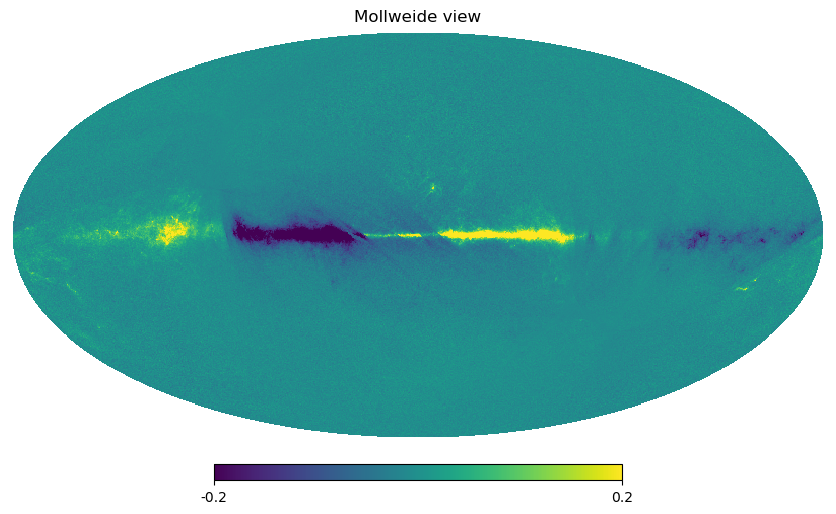

In [33]:
_min_max = dict(min=-0.2, max=0.2)
for m in _output_maps:
    hp.mollview(m, **_min_max)
    break

In [38]:
out_mask = np.ones(hp.nside2npix(NSIDE_OUTPUT))

In [40]:
_output_cls = []
for m in _output_maps:
    _output_cls.append(get_autopower(m, out_mask, _lmax))

In [50]:
_demo_avg_map_dg = downgrade_map_via_alm(_demo_avg_map, NSIDE_OUTPUT)

In [48]:
_demo_avg_cl = get_autopower(_demo_avg_map_dg, out_mask, get_lmax_for_nside(NSIDE_OUTPUT))

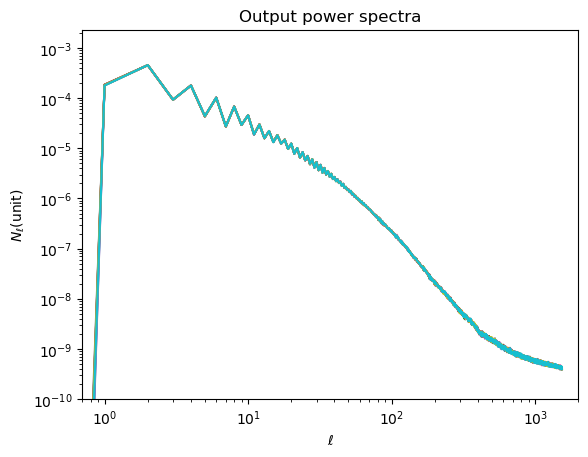

In [55]:
plot_many_ps(_output_cls, 
             labels=[f"Sim {i}" for i in range(N_OUTPUT_SIMS)],
             title="Output power spectra", 
             x_low=0.7, x_high=2000, 
             y_low=1e-10, y_high=None,
             legend=False, 
             focus_first=False
             )

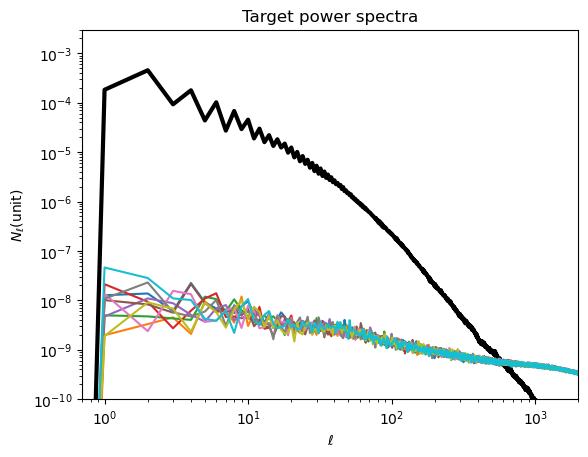

In [56]:
plot_many_ps([_demo_avg_cl, *_tgt_cls], 
             labels=["Avg"] + [f"Sim {i}" for i in range(N_OUTPUT_SIMS)],
             title="Target power spectra", 
             x_low=0.7, x_high=2000, 
             y_low=1e-10, y_high=None,
             legend=False, 
             focus_first=True
             )

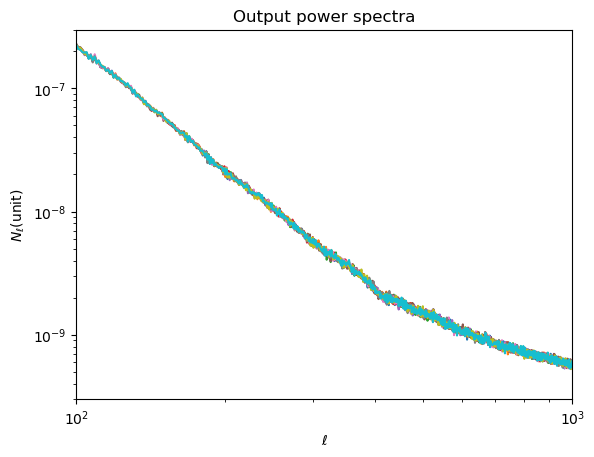

In [61]:
plot_many_ps(_output_cls, 
             labels=[f"Sim {i}" for i in range(N_OUTPUT_SIMS)],
             title="Output power spectra", 
             x_low=100, x_high=1000, 
             y_low=3e-10, y_high=3e-7,
             legend=False, 
             focus_first=False
             )

Compare that to Planck simulations: [visible here](show_planck_sims_545.ipynb#simulation-power-spectra)

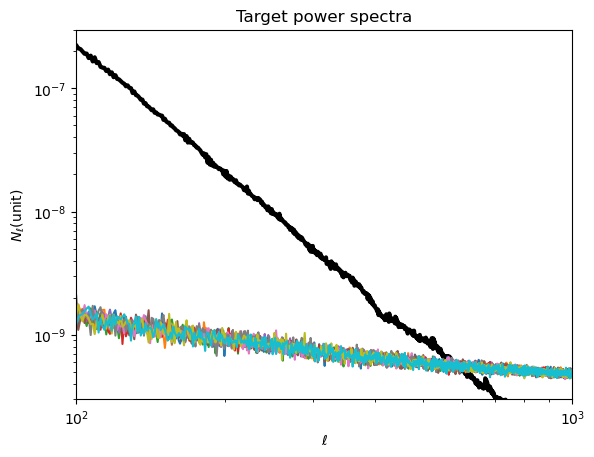

In [62]:
plot_many_ps([_demo_avg_cl, *_tgt_cls], 
             labels=["Avg"] + [f"Sim {i}" for i in range(N_OUTPUT_SIMS)],
             title="Target power spectra", 
             x_low=100, x_high=1000, 
             y_low=3e-10, y_high=3e-7,
             legend=False, 
             focus_first=True
             )